## Choice of step length

Every line search algorithm beginning at $\mathbf{x}_k$ chooses some direction $\mathbf{p}_k$ in which to step and some positive scalar $\alpha_k$ which determines the step length. That is, set
$$ \mathbf{x}_{k+1}=\mathbf{x}_k+\alpha_k\mathbf{p}_k $$

and repeat until convergence. In the most staightforward algorithm, **steepest descent**, we choose $\mathbf{p}_k=-\nabla f_k$, but the choice of $\alpha_k$ is more complicated. If we want to choose an *optimal* value of $\alpha_k$ in the direction $\mathbf{p}_k$, i.e. **exact line search**, we define

$$\phi(\alpha)=f(\mathbf{x}_k+\alpha \mathbf{p}_k)$$

(a "slice" of the function along the $\mathbf{p}_k$ direction, as shown below) and determine $\alpha_k>0$ such that $\phi'(\alpha)=0$.

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-11184-7_5/MediaObjects/447852_1_En_5_Fig2_HTML.png" width="75%" />


### Wolfe conditions

It is not feasible to perform exact line search for a general function since determining the optimal $\alpha_k$ requires excessive analytic calculation even for low-dimensional functions. Instead of calculating the optimal step size, we introduced the **Wolfe conditions** to determine a "good enough" step size, i.e. one that guarantees convergence in a reasonable number of iterations. Recall that the Wolfe conditions are given by

* Wolfe I (Armijo condition): $\qquad f_{k+1}\le f_k+c_1\alpha_k\mathbf{p}_k^T\nabla f_k \qquad \leftrightarrow\qquad \phi(\alpha_k)\le l(\alpha_k)$
* Wolfe II (curvature condition): $\quad \mathbf{p}_k^T\nabla f_{k+1}\ge c_2\mathbf{p}_k^T\nabla f_k \qquad\quad \leftrightarrow\qquad \phi'(\alpha_k)\ge c_2\phi'(0)$

where $0<c_1<c_2<1$, and generally provide an upper bound (Wolfe I) and a lower bound (Wolfe II) for $\alpha_k$ that guarantee convergence, though note that the "acceptable" values of $\alpha_k$ may form a disjoint set, particularly for highly non-convex functions, as shown in the image below:

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-11184-7_5/MediaObjects/447852_1_En_5_Fig7_HTML.png" width="50%" />

Wolfe I condition is much more important than Wolfe II condition: if $\alpha_k \rightarrow 0$, we're guaranteed to eventually converge, but a step size that's too large can prevent convergence.

In the backtracking algorithm, only the 1st Wolfe condition is checked.

# Exact Line Search

In [14]:
alpha = lambda x,y: ((x-1)**2+4*(2*y-1)**2)/(2*(x-1)**2+32*(2*y-1)**2)

x,y=np.random.rand()*5,np.random.rand()*5
print(f'At {x}, {y}\nalpha={alpha(x,y)}') # random point in [0,5]x[0,5]

At 4.161428945994024, 2.3017937814266762
alpha=0.1422109088412445


In [1]:
# define the function
g = lambda x,y: (x-1)**2 + (2*y-1)**2
# define derivatives of f to make the gradient
Dg = lambda x,y: np.array([2*(x-1), 4*(2*y-1)])

In [2]:
%%time
# plot the figure first
plt.figure(figsize=(6, 6))
X = np.linspace(0,5,300)  # 300 evenly spaced points on x-axis [0,5]
Y = np.linspace(0,5,300)  # 300 evenly spaced points on y-axis [0,5]
Xmesh, Ymesh = np.meshgrid(X,Y)  # 300x300 grid of points defined by X and Y above
Z = g(Xmesh,Ymesh)
CS = plt.contour(Xmesh, Ymesh, Z, 20, cmap='jet')
plt.clabel(CS,inline_spacing=0,fmt='%d')
plt.axis([0,5,0,5])
plt.xlabel('x')
plt.ylabel('y')

x0 = np.random.rand(2)*5  # initial point randomly chosen
x = x0.copy()
print(f'Initial x={x}')
dx = np.array([np.inf,np.inf]) # initial large gradient so while loop runs
tol = 1e-3            # stop when gradient is smaller than this amount
max_steps = 100       # Maximum number of steps to run the iteration
i=0                   # iteration count
while np.linalg.norm(dx)>tol and i<max_steps:
    dx = Dg(x[0],x[1])
    # new value of x
    xnew = x - alpha(x[0],x[1])*dx # note alpha is a function here!
    # add arrow to plot
    plt.arrow(x[0],x[1],-alpha(x[0],x[1])*dx[0],-alpha(x[0],x[1])*dx[1],color='b',
                      head_width=.1,length_includes_head=True)
    # update old value
    x = xnew
    # update iteration count
    i += 1
    print(f'In iteration {i}, alpha={alpha(x[0],x[1])}, and newx={x}')

print(f'After {i} iterations, approximate minimum is {g(x[0],x[1])} at {x}')
plt.title('Exact line search')
plt.show()

NameError: name 'plt' is not defined

### Backtracking algorithm

* Wolfe conditions are really difficult to find exactly, as we saw in the previous discussion.

* However, it's very easy to check if the Wolfe conditions are satisfied for a given $\alpha_k$.

The **backtracking algorithm** is as follows:

1. Set a large initial value $\tilde\alpha$, e.g. $\tilde\alpha=1$.
2. Check if Wolfe I is satisfied, i.e. if $f_{k+1}\le f_k+c_1\tilde\alpha\mathbf{p}_k^T\nabla f_k$.
3. If true, terminate. If false, set $\tilde\alpha\leftarrow\rho\tilde\alpha$, for $\rho\in(0,1)$.
4. Repeat 2-3 until true.

 $$g(x,y)=(x-1)^2+(2y-1)^2$$
 

Below we implement the backtracking algorithm on our test function $g(x,y)$ with the same initial starting point as exact line search above and compare the results. We choose $c_1=0.1$ and $\rho=0.75$ with an initial value of $\tilde\alpha=1$.

In [17]:
def WolfeI(alpha,f,x,p,c1=0.1):
    '''Return True/False if Wolfe condition I is satisfied for the given alpha'''
    LHS = f(x[0]+alpha*p[0], x[1]+alpha*p[1])
    RHS = f(x[0],x[1])-c1*alpha*np.dot(p,p)
    return LHS <= RHS

Initial x=[3.38674194 3.78675357]
In iteration 0, 1st backtrack: alpha=0.75
In iteration 0, 1st backtrack: alpha=0.5625
In iteration 0, 1st backtrack: alpha=0.421875
In iteration 0, 1st backtrack: alpha=0.31640625
In iteration 0, 1st backtrack: alpha=0.2373046875
In iteration 0, 1st backtrack: alpha=0.177978515625
In iteration 1, alpha=0.177978515625 after 6 backtracks, and newx=[ 2.53716436 -0.8930186 ]
In iteration 2, alpha=0.2373046875 after 5 backtracks, and newx=[1.80761175 1.75154015]
In iteration 3, alpha=0.177978515625 after 6 backtracks, and newx=[ 1.52013667 -0.03043791]
In iteration 4, alpha=0.177978515625 after 6 backtracks, and newx=[1.33499036 0.72481451]
In iteration 5, alpha=0.2373046875 after 5 backtracks, and newx=[1.1760008  0.29801822]
In iteration 6, alpha=0.177978515625 after 6 backtracks, and newx=[1.11335208 0.58560556]
In iteration 7, alpha=0.2373046875 after 5 backtracks, and newx=[1.05955412 0.42308875]
In iteration 8, alpha=0.177978515625 after 6 backtracks,

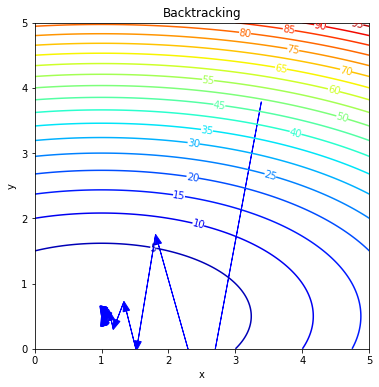

Wall time: 224 ms


In [18]:
%%time
# plot the figure first
plt.figure(figsize=(6, 6))
X = np.linspace(0,5,300)  # 300 evenly spaced points on x-axis [0,5]
Y = np.linspace(0,5,300)  # 300 evenly spaced points on y-axis [0,5]
Xmesh, Ymesh = np.meshgrid(X,Y)  # 300x300 grid of points defined by X and Y above
Z = g(Xmesh,Ymesh)
CS = plt.contour(Xmesh, Ymesh, Z, 20, cmap='jet')
plt.clabel(CS,inline_spacing=0,fmt='%d')
plt.axis([0,5,0,5])
plt.xlabel('x')
plt.ylabel('y')


x0 = np.random.rand(2)*5  # initial point randomly chosen
x = x0.copy()         # same initial point as before
print(f'Initial x={x}')
dx = np.array([np.inf,np.inf]) # initial large gradient so while loop runs
tol = 1e-3            # stop when gradient is smaller than this amount
max_steps = 100       # Maximum number of steps to run the iteration
rho = 0.75            # parameter for backtracking algorithm
i=0                   # iteration count

while np.linalg.norm(dx)>tol and i<max_steps:
    dx = Dg(x[0],x[1])
    
    # backtracking
    a = 1
    j = 0   # keep track of how many backtracking iterations
    while not WolfeI(a,g,x,-dx):
        a *= rho
        j += 1
        if i == 0:
            print(f'In iteration {i}, 1st backtrack: alpha={a}')

    # new value of x
    xnew = x - a*dx
    
    # add arrow to plot
    plt.arrow(x[0],x[1],-a*dx[0],-a*dx[1],color='b',head_width=.1,length_includes_head=True)
    # update old value
    x = xnew
    # update iteration count
    i += 1
    print(f'In iteration {i}, alpha={a} after {j} backtracks, and newx={x}')

print(f'After {i} iterations, approximate minimum is {g(x[0],x[1])} at {x}')
plt.title('Backtracking')
plt.show()

**Downside**: Doesn't check 2nd Wolfe condition. Potentially not worth checking 2nd wolfe condition since we'll achieve convergence anyways, and since the while loop stops immediately once $\alpha$ satisfies the 1st Wolfe condition, the step size won't be too short.

You could make a more complicated version of Backtracking to satisfy the 2nd Wolfe condition: One idea is to iteratively increase $\alpha$ by a small amount after the backtracking step if Wolfe II isn't satisfied.

It's doable, but it's not worth the computational cost - computing Wolfe II requires you to calculate the gradient $\nabla f(x_k)$ and $\nabla f(x_{k+1})$, which is computationally costly for systems with a large amount of variables.

## Rate of Convergence

We have mentioned the idea of converging "fast enough" several times, e.g. in relation to Wolfe condition II, but can we actually quantify the rate of convergence? Indeed, we define the rate of convergence $p\ge1$ to be the value such that

$$ 0< \lim_{k\to\infty} \frac{\|\mathbf{x}_{k+1}-\mathbf{x}^*\|}{\|\mathbf{x}_k-\mathbf{x}^*\|^p} \equiv L < \infty $$

where $\mathbf{x}^*$ is the known minimizer, i.e. the terminal point satisfying $\nabla f(\mathbf{x}^*)=\mathbf{0}$. If $p=1$ and the limit is also equal to 1, we say the convergence is **sub-linear**. If $p=1$ and the limit is smaller than 1, we say the convergence is **linear**. If $p>1$, we say the convergence is **super-linear**. If the limit is equal to 0 for all $p\ge1$, we say the order of convergence is $\infty$.

Steepest descent convergence is linear at worst.

Other methods will converge more quickly than steepest descent.

Here, we can show how to calculat ethe order of convergence of any method of an objective function, providing the method does converge.

Suppose that we have run an iterative procedure to the point of convergence after $N$ iterations and kept track of the sequence $\{\mathbf{x}_k\}_{k=0}^N$. Then we can simply assume $\mathbf{x}^*\equiv\mathbf{x}_N$ and find a value of $p$ for which the limit above is finite and non-zero. But how to find that $p$?

Note that if we define
$$ e_k = \|\mathbf{x}_k-\mathbf{x}^*\| $$
then according to the limit above, as $k\to\infty$,
$$ e_{k+1}\approx L e_k^p $$

Then, since this is true of any large $k$, we can simply shift indices down and take a ratio to get

$$ \frac{e_{k+1}}{e_k} \approx \frac{Le_k^p}{Le_{k-1}^p} = \left(\frac{e_k}{e_{k-1}}\right)^p $$

which upon solving for $p$ yields
$$ p\approx \frac{\ln(e_{k+1}/e_k)}{\ln(e_k/e_{k-1})} $$

Furthermore, it can be shown that as $k\to\infty$,
$$ \frac{e_{k+1}}{e_k} =\frac{\|\mathbf{x}_{k+1}-\mathbf{x}^*\|}{\|\mathbf{x}_k-\mathbf{x}^*\|} \approx \frac{\|\mathbf{x}_{k+1}-\mathbf{x}_k\|}{\|\mathbf{x}_k-\mathbf{x}_{k-1}\|} $$
so that
$$ p\approx \frac{\ln\left(\frac{\|\mathbf{x}_{k+1}-\mathbf{x}_k\|}{\|\mathbf{x}_k-\mathbf{x}_{k-1}\|}\right)}{\ln\left(\frac{\|\mathbf{x}_{k}-\mathbf{x}_{k-1}\|}{\|\mathbf{x}_{k-1}-\mathbf{x}_{k-2}\|}\right)} $$


Below, we calculate the rate of convergence for our favorite function $g(x,y)$, this time decreasing the tolerance in the gradient to $10^{-8}$ and relaxing the value of $c_1$ in the Wolfe condition to $0.001$ to force the algorithm to take a decently large number of steps:

In [8]:
x = x0.copy()         # same initial point as before
path = [x]
print(f'Initial x={x}')
dx = np.array([np.inf,np.inf]) # initial large gradient so while loop runs
tol = 1e-8            # stop when gradient is smaller than this amount
max_steps = 1000      # Maximum number of steps to run the iteration
rho = 0.75            # parameter for backtracking algorithm
i=0                   # iteration count
while np.linalg.norm(dx)>tol and i<max_steps:
    dx = Dg(x[0],x[1])
    
    # backtracking
    a = 1
    j = 0   # keep track of how many backtracking iterations
    while not WolfeI(a,g,x,-dx,c1=0.001):
        a *= rho
        j += 1

    # new value of x
    xnew = x - a*dx
    path.append(xnew)
    
    # update old value
    x = xnew
    # update iteration count
    i += 1

path=np.array(path)
print(f'After {i} iterations, approximate minimum is {g(x[0],x[1])} at {x}')

Initial x=[0.99532048 0.31676509]
After 177 iterations, approximate minimum is 4.600262783295857e-18 at [1.  0.5]


In [9]:
print(path[:20,:])  # first 20 steps

[[0.99532048 0.31676509]
 [0.99754142 0.66462511]
 [0.99870829 0.35209463]
 [0.99932135 0.63288373]
 [0.99964344 0.38061227]
 [0.99981267 0.60726241]
 [0.99990158 0.40363143]
 [0.99994829 0.58658114]
 [0.99997283 0.42221226]
 [0.99998573 0.56988743]
 [0.9999925  0.43721052]
 [0.99999606 0.55641243]
 [0.99999793 0.44931696]
 [0.99999891 0.54553554]
 [0.99999943 0.45908916]
 [0.9999997  0.53675583]
 [0.99999984 0.46697718]
 [0.99999992 0.52966894]
 [0.99999996 0.47334431]
 [0.99999998 0.52394847]]


In [10]:
print(np.diff(path,axis=0)[:20])  # x_{k+1}-x_k

[[ 2.22094369e-03  3.47860018e-01]
 [ 1.16686299e-03 -3.12530485e-01]
 [ 6.13058876e-04  2.80789108e-01]
 [ 3.22095386e-04 -2.52271464e-01]
 [ 1.69225896e-04  2.26650143e-01]
 [ 8.89096994e-05 -2.03630988e-01]
 [ 4.67123225e-05  1.82949716e-01]
 [ 2.45422163e-05 -1.64368885e-01]
 [ 1.28942504e-05  1.47675171e-01]
 [ 6.77451826e-06 -1.32676911e-01]
 [ 3.55926838e-06  1.19201912e-01]
 [ 1.87000624e-06 -1.07095468e-01]
 [ 9.82483748e-07  9.62185846e-02]
 [ 5.16187750e-07 -8.64463846e-02]
 [ 2.71200205e-07  7.76666736e-02]
 [ 1.42486045e-07 -6.97786521e-02]
 [ 7.48608323e-08  6.26917577e-02]
 [ 3.93311794e-08 -5.63246261e-02]
 [ 2.06642330e-08  5.06041563e-02]
 [ 1.08567942e-08 -4.54646716e-02]]


In [11]:
err = np.linalg.norm(np.diff(path,axis=0),axis=1) # ||x_{k+1}-x_k||
print(err[:20]) # error in first 20 steps

[0.34786711 0.31253266 0.28078978 0.25227167 0.22665021 0.20363101
 0.18294972 0.16436889 0.14767517 0.13267691 0.11920191 0.10709547
 0.09621858 0.08644638 0.07766667 0.06977865 0.06269176 0.05632463
 0.05060416 0.04546467]


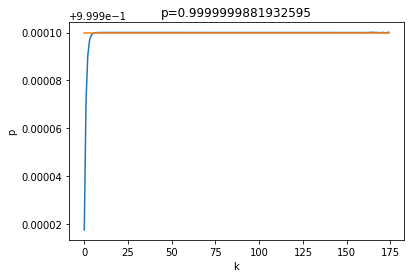

In [12]:
pp=np.zeros(len(err)-2)
for i in range(len(pp)):
    pp[i]=(np.log(err[i+2]/err[i+1])/np.log(err[i+1]/err[i]))
    
p=np.mean(pp[-10:])  # p is mean of last 10 iterations
    
plt.plot(pp)
plt.plot(pp*0+p)
plt.xlabel('k')
plt.ylabel('p')
plt.title(f'p={p}')
plt.show()

In [13]:
err[-1]/err[-2]   # limit value

0.8984375067058369

Indeed we see that the algorithm does converge linearly since $p=1$, $L<1$.